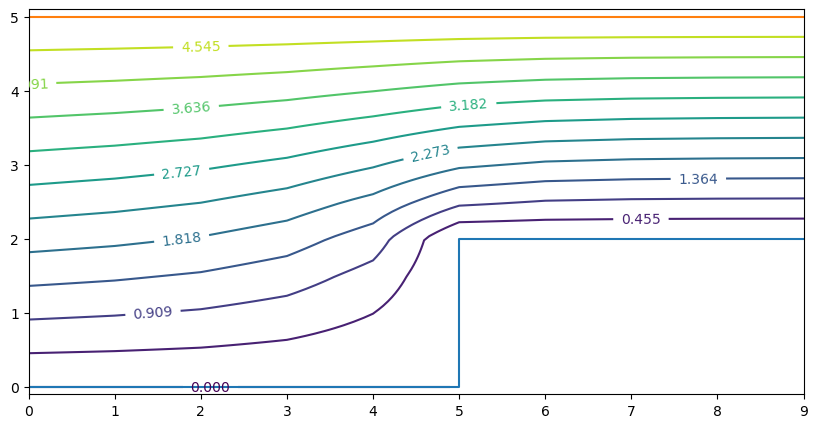

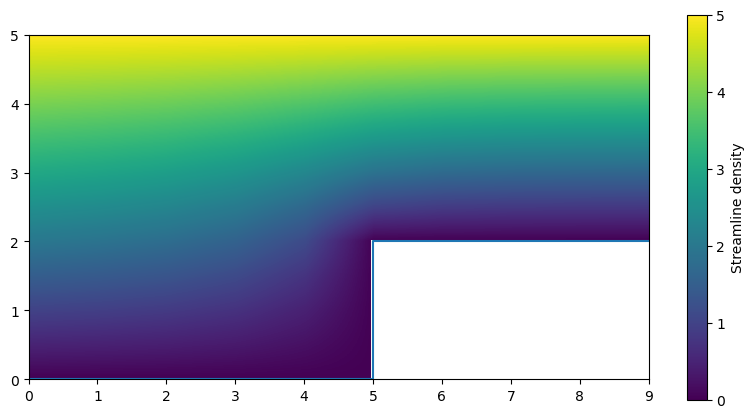

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.47070731, 0.42848982, 0.35451121, 0.21946337,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.94464581, 0.86491992, 0.72428974, 0.46003061,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.5       , 1.42467724, 1.3165761 , 1.1249755 , 0.74954073,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [2.        , 1.91290326, 1.78910715, 1.5716198 , 1.13257733,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [2.5       , 2.41030413, 2.285061  , 2.07365288, 1.68899765,
        1.01586394, 0.88472604, 0.84993429, 0.8384784 , 0.83333333],
       [3.        , 2.91659181, 2.8025561 , 2.61899773, 2.31753759,
        1.89622893, 1.74536555, 1.69403462, 1.6753791 , 1.66666667],
       [3.5       , 3.43053637, 3.3374318

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def channel_solve(phi, n_streamlines, tol = 1e-10, maxit = 1000):
    x = np.arange(0, 10, 1)
    y = np.arange(0, 5.5, 0.5)
    nx, ny = len(x), len(y)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    #accounting for step in channel
    i_step5 = np.where(x >=5)[0][0]
    j_y2 = np.where(np.isclose(y, 2))[0][0]

    #creating matrix and adding mask for step thing
    mask = np.ones((ny,nx),dtype =bool)
    mask[:j_y2, i_step5:] = False

    ### starting psi and BSc
    psi = np.zeros((ny,nx), dtype=float)

    psi[-1,:] = phi #top wall
    psi[0, :i_step5] = 0 #bottom wall
    psi[j_y2, i_step5:] = 0 #new bottol wall at y=2
    psi[:j_y2 + 1, i_step5] = 0 #wall at x=5

    psi[:, 0] = phi * (y / 5) #inlet for each streamline

    psi[:j_y2, -1] = 0 #outlet for blocked step
    psi[j_y2:, -1] = phi * ((y[j_y2:]- 2)/3) #outlet for actual channel

    #nodes for boundaries and step
    step = np.zeros_like(mask, dtype=bool)
    step[~mask] = True #step
    step[-1,:] = True #top wall
    step[:, 0] = True #bottom wall
    step[:, -1] = True #outlet
    step[0, :i_step5] = True #bottom inlet till step
    step[j_y2, i_step5:] = True #bottom new wall at y=2
    step[:j_y2 +1, i_step5] = True #wall from y=0 toi y=2

    #coeff for Laplace
    ax = 1 / dx**2
    ay = 1 / dy**2
    bot = 2 * (ax + ay)

    #fix for step neighbouring points, to treat wall as 0
    def fixer(i,j):
        if 0 <= i < ny and 0 <= j < nx and mask[i,j]:
            return psi[i,j]
        return 0
    
    ###olve Laplace
    #loop for max iterations
    for it in range(maxit):
        delta = 0

        #loop for x and y values
        for i in range(1, ny-1):
            for j in range(1,nx -1):
                
                #check whether the point is either the step or a boundary/fixed poitn
                if not mask[i,j] or step[i,j]:
                    continue
                
                #compute east, west, north and south values
                W = fixer(i, j-1)
                E = fixer(i, j+1)
                N = fixer(i+1, j)
                S = fixer(i-1, j)

                psi_new = (ax* (W + E) + ay *(S + N)) / bot

                diff = abs(psi_new - psi[i,j])
                if diff > delta:
                    delta = diff

                psi[i,j] = psi_new
        
        if delta < tol:
            break

    ###make grid for streamlines plot
    x_streamline = np.linspace(0, 10, (len(x) - 1) * 10 +1)
    y_streamline = np.linspace(0, 5.5, (len(y) -1) *10 + 1)

    #interpolation for smooth line and to avoid weird kink in the corner of the step
    psi_x_inter_streamline = np.zeros((ny, len(x_streamline)))
    for i in range(ny):
        psi_x_inter_streamline[i, :] = np.interp(x_streamline, x, psi[i, :])

    psi_streamline = np.zeros((len(y_streamline), len(x_streamline)))
    for j in range(len(x_streamline)):
        psi_streamline[:, j] = np.interp(y_streamline, y, psi_x_inter_streamline[:, j])

    Xstream, Ystream = np.meshgrid(x_streamline, y_streamline)

    #new mask for step for different grid size
    mask_streamline = np.ones_like(Xstream, dtype=bool)
    mask_streamline[(Xstream>= 5) & (Ystream < 2)] = False

    #plot points for streamline, ignoring ones inside the step so that they do not still create a line at the bottom
    psi_plotting_stream = psi_streamline.copy()
    psi_plotting_stream[~mask_streamline] = np.nan

    ###make grid for heatmap plot
    x_heatmap = np.linspace(0, 10, (len(x) - 1) * 30 + 1)
    y_heatmap = np.linspace(0, 5.5, (len(y) -1) * 30 +1 )

    psi_x_inter_heatmap = np.zeros((ny, len(x_heatmap)))
    for i in range(ny):
        psi_x_inter_heatmap[i, :] = np.interp(x_heatmap, x, psi[i, :])
    
    psi_heatmap = np.zeros((len(y_heatmap), len(x_heatmap)))
    for j in range(len(x_heatmap)):
        psi_heatmap[:, j] = np.interp(y_heatmap, y, psi_x_inter_heatmap[:, j])
    
    Xheat, Yheat = np.meshgrid(x_heatmap, y_heatmap)
    
    mask_heatmap = np.ones_like(Xheat, dtype=bool)
    mask_heatmap[(Xheat>=5) & (Yheat<2)] = False

    psi_plotting_heat = psi_heatmap.copy()
    psi_plotting_heat[~mask_heatmap] = np.nan

    ###plotting graphsssss

    #streamines
    streamlines_list = np.linspace(0, phi, n_streamlines)

    plt.figure(figsize=(10,5))
    psi_on_line = plt.contour(Xstream, Ystream, psi_plotting_stream, levels=streamlines_list)
    plt.clabel(psi_on_line, inline = True)

    plt.plot([0,5,5,9], [0,0,2,2]) #plotting bottom streamline along wall
    plt.plot([0,9], [5,5]) #plotting top wall streamline

    plt.xlim(0,9)
    plt.ylim(-0.1,5.1)
    plt.show()

    #heatmap
    plt.figure(figsize=(10,5))
    plt.imshow(psi_plotting_heat, origin='lower', extent= [x_heatmap.min(), x_heatmap.max(), y_heatmap.min(), y_heatmap.max()])
    plt.colorbar(label = 'Streamline density')
    plt.plot([0,5,5,9], [0,0,2,2]) #plotting bottom streamline along wall
    plt.plot([0,9], [5,5]) #plotting top wall streamline
    plt.xlim(0,9)
    plt.ylim(0,5)
    plt.show()

    return psi

channel_solve(5, 12)
    